In [1]:
#Error analysis and Explainaibility
import pandas as pd
import numpy as np
import torch
import random
import numpy as np

from transformers import AutoTokenizer, BertForMaskedLM 
from datasets import load_dataset, Dataset, DatasetDict
from matplotlib import pyplot as plt

In [2]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cpu')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = BertForMaskedLM.from_pretrained("bert-base-cased")

def get_probs(sentence, word_idx):
    input_ids = tokenizer.encode(sentence)
    input_ids = torch.tensor([input_ids])
    logits = bert(input_ids)[0][0]
    sorted_probs = logits[word_idx].sort(descending=True)

    return sorted_probs

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
sentence = f"We want to go to {tokenizer.mask_token}."
sorted_probs = get_probs(sentence, 6)
for i in range(10):
    token = tokenizer._convert_id_to_token(sorted_probs.indices[i].numpy().tolist())
    conf = sorted_probs.values[i].detach().numpy().tolist()
    print(f"{token}: {conf}")

sleep: 8.723100662231445
hell: 8.661073684692383
school: 8.478261947631836
bed: 8.442703247070312
work: 8.129664421081543
heaven: 8.072664260864258
church: 8.0494966506958
college: 7.654545307159424
Italy: 7.634221076965332
her: 7.583528995513916


In [33]:
import spacy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
dataset = load_dataset("copenlu/answerable_tydiqa")

#split data 
train_set = dataset["train"]
validation_set = dataset["validation"]

train_set = train_set.to_pandas()
validation_set = validation_set.to_pandas()

#preprocess data

eng_train_set = train_set[train_set['language'] == 'english']
fin_train_set = train_set[train_set['language'] == 'finnish']
jap_train_set = train_set[train_set['language'] == 'japanese']

eng_validation_set = validation_set[validation_set['language'] == 'english']
fin_validation_set = validation_set[validation_set['language'] == 'finnish']
jap_validation_set = validation_set[validation_set['language'] == 'japanese']


Using custom data configuration copenlu--nlp_course_tydiqa-cceecfb5416d988a
Found cached dataset parquet (/home/gadelampe/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-cceecfb5416d988a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
def get_answerability(annotations):
    answerable = []
    for annot in annotations:
        if -1 in annot['answer_start']:
            answerable.append(0)
        else:
            answerable.append(1)
    return answerable


eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
fin_train_set['answerable'] = get_answerability(fin_train_set['annotations'].tolist())
jap_train_set['answerable'] = get_answerability(jap_train_set['annotations'].tolist())

eng_validation_set['answerable'] = get_answerability(eng_validation_set['annotations'].tolist())
fin_validation_set['answerable'] = get_answerability(fin_validation_set['annotations'].tolist())
jap_validation_set['answerable'] = get_answerability(jap_validation_set['annotations'].tolist())

jap_train_set.columns

/tmp/ipykernel_62572/3288686915.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
/tmp/ipykernel_62572/3288686915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_train_set['answerable'] = get_answerability(fin_train_set['annotations'].tolist())
/tmp/ipykernel_62572/3288686915.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Index(['question_text', 'document_title', 'language', 'annotations',
       'document_plaintext', 'document_url', 'answerable'],
      dtype='object')

In [9]:
def question_parag_combine(questions, paragraphs):
    """
    This function combines the questions and paragraphs into a single text
    Args:
        questions: list of questions
        paragraphs: list of paragraphs
    Returns:
        list of combined questions and paragraphs
    """
    training_data = []
    for index in range(len(questions)):
        training_data += [questions[index] + "\n" + paragraphs[index]]
        
    return training_data

def make_df(train_set, validation_set):
  d_q = train_set['question_text'].tolist()
  d_p = train_set['document_plaintext'].tolist()
  training_data = question_parag_combine(d_q,d_p)
  training_labels = train_set['answerable'].tolist()

  d_q = validation_set['question_text'].tolist()
  d_p = validation_set['document_plaintext'].tolist()
  validation_data = question_parag_combine(d_q,d_p)
  validation_labels = validation_set['answerable'].tolist()



  data_set = {}
  sets = [['train',training_data, training_labels], ['val', validation_data, validation_labels]]
  for meta in sets:
      data_set[meta[0]] = {}
      data_set[meta[0]]['text'] = []
      data_set[meta[0]]['labels'] = []
      
      for ind, text in enumerate(meta[1]):
          data_set[meta[0]]['text'].append(text)
          data_set[meta[0]]['labels'].append(meta[2][ind])

          

          
  data_set = DatasetDict({'train':Dataset.from_dict(data_set['train']),
                          'valid':Dataset.from_dict(data_set['val'])\
                        })
  return data_set

eng_set = make_df(eng_train_set, eng_validation_set)
fin_set = make_df(fin_train_set, fin_validation_set)
jap_set = make_df(jap_train_set, jap_validation_set)

eng_set

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 7389
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 990
    })
})

In [10]:
train_set = eng_set['train']
val_set = eng_set['valid']

In [11]:
n = 100

#print(dft_eng['document_plaintext'].values)
vectorizer = TfidfVectorizer(max_features=10000)
features = vectorizer.fit_transform(train_set['text'])
# the raw/textual n-grams the vectorizer is using
feature_array = np.array(vectorizer.get_feature_names())
# TF-IDF scores of the words in each instance of the input datasets
tfidf_sorting = np.argsort(features.toarray()).flatten()[::-1]

# With a TF-IDF Vecotrizer, we can already tell the words that have high TF-IDF scores
# Even before feeding them to the model:
# Look-up of the top-n words at the indices with 1) highest and 2) lowest scores 
print(feature_array[tfidf_sorting][:2])
print(feature_array[tfidf_sorting][-2:])

/home/gadelampe/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['recall' 'mayor']
['papal' '00']


In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
features = vectorizer.fit_transform(train_set['text'])
# training a linear model, which is interpretable by design
lr = LogisticRegression(penalty='l2', max_iter=1000, multi_class='ovr')
lr.fit(features, train_set['labels'])

LogisticRegression(max_iter=1000, multi_class='ovr')

In [13]:
#features_test = vectorizer.fit_transform(dfv_eng.values[:, 0])
#preds_tfidf = lr.predict(features_test)

In [36]:
features_valid = vectorizer.transform(val_set['text'])
preds_valid_tfidf = lr.predict(features_valid)

In [15]:
from tqdm import tqdm
import nltk

In [16]:
from bpemb import BPEmb

# Load english model with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=100, vs=25000)

In [17]:
def get_bpemb_features(dataset, bpemb):
  # With bpemb we can tokenize and embed an entire document using .embed(x)
  X = [bpemb.embed(x).mean(0) for x in tqdm(dataset['text'])]
  y = dataset['labels']
 
  return X,y

In [18]:
X_train,y_train = get_bpemb_features(train_set, bpemb_en)
X_valid,y_valid = get_bpemb_features(val_set, bpemb_en)
lr_bpemb = LogisticRegression(penalty='l2', max_iter=1000)#, multi_class='multinomial')
lr_bpemb.fit(X_train, y_train)

100%|██████████| 990/990 [00:00<00:00, 1313.77it/s]


LogisticRegression(max_iter=1000)

In [19]:
#preds_bpemb = lr_bpemb.predict(X_test)
preds_valid_bpemb = lr_bpemb.predict(X_valid)
preds_valid_bpemb

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [37]:
# TF-IDF model 
y_valid = val_set['labels']
report = classification_report(y_valid, preds_valid_tfidf, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.739958,0.707071,0.723140,495.000000
1,0.719536,0.751515,0.735178,495.000000
accuracy,0.729293,0.729293,0.729293,0.729293
macro avg,0.729747,0.729293,0.729159,990.000000
weighted avg,0.729747,0.729293,0.729159,990.000000


In [21]:
# BPEmb model 
report = classification_report(y_valid, preds_valid_bpemb, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.694624,0.652525,0.672917,495.000000
1,0.672381,0.713131,0.692157,495.000000
accuracy,0.682828,0.682828,0.682828,0.682828
macro avg,0.683502,0.682828,0.682537,990.000000
weighted avg,0.683502,0.682828,0.682537,990.000000


In [22]:
confusion_matrix(val_set['labels'], preds_valid_tfidf)


array([[350, 145],
       [123, 372]])

In [23]:
confusion_matrix(val_set['labels'], preds_valid_bpemb)

array([[323, 172],
       [142, 353]])

0


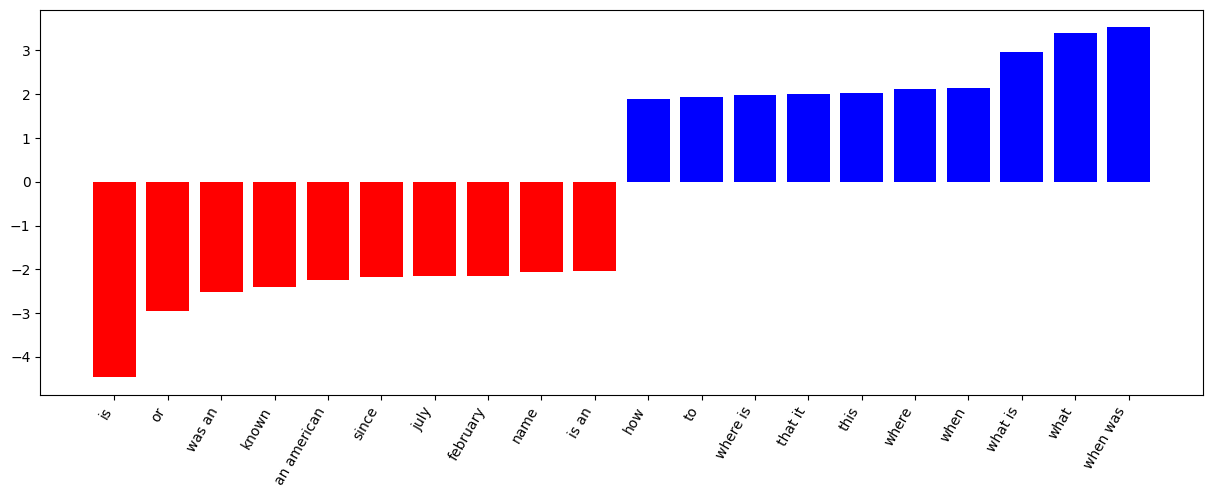

1


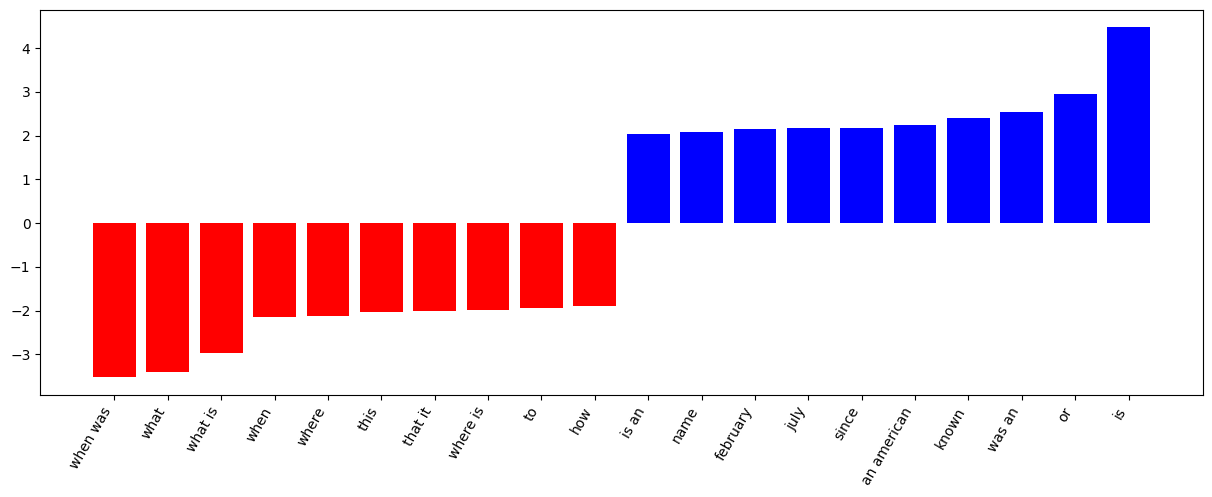

In [45]:
top_features = 10
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = lr.coef_

for i, cls in enumerate(lr.classes_): # for each of the classes
  print(cls)
  # get the weights for the class
  coef = all_class_coef[0]
  if cls == 0:
    coef = -coef
  # find the top negative and positive features for the class
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  # combine them in one array
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot - humans tend to understand better plot visualizations
  feature_names = vectorizer.get_feature_names_out()
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()

### Error classification

In [46]:
# get the probability of the chosen model
valid_pred_prob = lr_bpemb.predict_proba(X_valid)

In [62]:
test_val_set = val_set.to_pandas()

test_val_set

,text,labels
0,What is a way to increase your wound healing s...,1
1,Who founded the Burntisland Shipbuilding Compa...,1
2,What is the surface area of the human cortex?\...,1
3,When did the case of R (Factortame Ltd) v Secr...,1
4,When was Quezon City founded?\nWhen Quezon Cit...,1
...,...,...
985,What's the average income in West Virginia?\nN...,0
986,How often do LSAT tests take place?\nA recent ...,0
987,How much does a bushel of barley weigh?\n\nThe...,0
988,What is the most common first word by babies?\...,0


In [72]:
from collections import defaultdict

# collect correct and wrong predictions, keeping the confidence of the prediction
errors = defaultdict(lambda: [])
correct_preds = defaultdict(lambda: [])

for (i, instance), pred, pred_score in zip(test_val_set.iterrows(), preds_valid_bpemb, valid_pred_prob):
  # get the index/id of the gold class in the probability array (n_classes x 1)
  index_of_class = np.where(lr_bpemb.classes_ == instance[1])
  # get the index/id of the predicted class in the probability array (n_classes x 1)
  index_of_pred_class =  np.where(lr_bpemb.classes_ == pred)
  # depending on whether the prediction is correct, collect the instances as errors or correct predictions
  # index 1 is the label or answerability, index 0 is the text
  if pred != instance[1]:
    errors[instance[1]].append((instance[0], pred_score[index_of_class], pred_score[index_of_pred_class], pred))
  else:
    correct_preds[instance[1]].append((instance[0], pred_score[index_of_class], pred_score, pred))

In [83]:
import pprint

for cls in lr_bpemb.classes_:
  print('Answerability = ', cls)
  print('High probability for correct class')
  # sort the errors by the probability of the gold class and look at the:
  # 1. instances where the gold class had a high probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[-10:])
  print()
  print('Answerability = ', cls)
  print('Low probability for correct class')
  # 1. instances where the gold class had a low probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[:10])
  print()
  print()

Answerability =  0
High probability for correct class
[('How long does it take diamond to form from carbon?\n'
  'Kimberlites can be found in narrow (1 to 4 metres) dikes and sills, and in '
  'pipes with diameters that range from about 75 m to 1.5 km. Fresh rock is '
  'dark bluish green to greenish gray, but after exposure rapidly turns brown '
  'and crumbles.[54] It is hybrid rock with a chaotic mixture of small '
  'minerals and rock fragments (clasts) up to the size of watermelons. They '
  'are a mixture of xenocrysts and xenoliths (minerals and rocks carried up '
  'from the lower crust and mantle), pieces of surface rock, altered minerals '
  'such as serpentine, and new minerals that crystallized during the eruption. '
  'The texture varies with depth. The composition forms a continuum with '
  'carbonatites, but the latter have too much oxygen for carbon to exist in a '
  'pure form. Instead, it is locked up in the mineral calcite (CaCO3).[47]',
  array([0.49016164]),
  arra

In [76]:
# We can check for some instances what were their TF-IDF scores (the input for the model)
text = 'As of November2015, Greater Adelaide had an unemployment rate of 7.4% with'
print(vectorizer.transform([text]))
text = 'As of November2015, Greater Adelaide had an unemployment rate of 7.4% with'
print([word for word in text.lower().split() if word in vectorizer.vocabulary_])

  (0, 973)	0.21888310070291275
  (0, 666)	0.6118909206181095
  (0, 585)	0.2527999655829962
  (0, 374)	0.3301630727595814
  (0, 119)	0.5486222537075058
  (0, 117)	0.1978174117396409
  (0, 86)	0.25425598641627895
['as', 'of', 'had', 'an', 'rate', 'of', 'with']


In [82]:
# do the same for correct predictions
for cls in lr_bpemb.classes_:
  print('Answerability = ', cls)
  print('High probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[-10:])
  print()
  print('Answerability = ', cls)
  print('Low probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[:10])
  print()
  print()

Answerability =  0
High probability for correct class
[("What is Texas' public rail system called?\n"
  'Route map: Attached KML Error: KML file not found',
  array([0.9428138]),
  array([0.9428138, 0.0571862]),
  0),
 ("What's Dagger's power?\n"
  'Luke Cage calls Cloak, who drops the New Avengers at the top of Stark Tower '
  "to steal one of Tony Stark's quinjets. When Cage offers to take him with "
  'them to find the downed Skrull ship, Cloak refuses, and vanishes.[52]',
  array([0.95088376]),
  array([0.95088376, 0.04911624]),
  0),
 ('How did fast food start?\n'
  'To make quick service possible and to ensure accuracy and security, many '
  'fast food restaurants have incorporated hospitality point of sale systems. '
  'This makes it possible for kitchen crew people to view orders placed at the '
  'front counter or drive through in real time. Wireless systems allow orders '
  'placed at drive through speakers to be taken by cashiers and cooks. Drive '
  'through and walk throug